In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# reading the data frame

df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Mall_Customers.csv')

Take a look at the data.

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


There are five features in the dataset. The first one is CustomerID, this feature is the unique identifier of each customer, we can drop this feature since it doesn't provide us with any useful cluster.<br>
Next one is Gender, since this one is a categorical variable, it needs to be encoded and converted into numeric.<br>
Other features will need to scaked to follow a normal distribution (mean 0, std 1) before being fed into the model. 

### Standardizing variables

First, let's standardize all variable in the dataset to get them around the same scale.

In [ ]:
col_names = ['Annual Income (k$)','Age', 'Spending Score (1-100)']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


### One-hot encoding

Next, we convert the values in 'gender' feature into numeric variable. We can do this with Pandas using pd.get_dummies()

In [ ]:
gender = df['Gender']
newdf = scaled_features.join(gender)
newdf = pd.get_dummies(newdf, prefix=None, prefix_sep='_',
                       dummy_na=False, columns=None, sparse=False,
                       drop_first=False, dtype=None)
newdf = newdf.drop(['Gender_Male'], axis=1)
age = df.Age
newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1


We drop the 'Gender_Male' column from the data since this values can be inferred from the 'Gender_Female'.

### Building the clustering model

For building k-mean model, we need to find the best number of clusters to start with. One way of doing this is draw the elbow curve and select the value of cluster where the inertia (value shows how well a dataset was clustered by k-means) begins to decrease slowly.


Text(0, 0.5, 'Inertia')

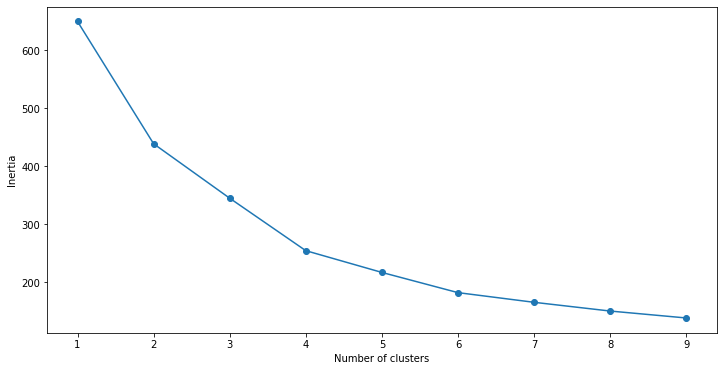

In [ ]:
SSE = []

for cluster in range(1, 10):
  kmeans = KMeans(n_clusters=cluster, init='k-means++')
  kmeans.fit(newdf)
  SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame.Cluster, frame.SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

We can see that the optimal number of clusters is 4.

#### Evaluate model




To evalue a clustering model, we will use silhouette coefficient or silhouette score.<br><br>
This score range from -1 to 1. The higher the silhouette score, the better the model.<br><br>
This work as measuring the distance between all the data points within the same cluster. The lower the distance, the better score. It also measures the distance between an object and the data points in the nearest cluster. The higher the distance, the better.

In [ ]:
# First, build a model with 4 clusters

kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(newdf)

# Then, print the silhouette score of this model

print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.35027020434653977


The silhouette score is about 0.35. This isn't a bad model but we can do better and try getting highest cluster separation.<br><br>
But first, let's visualize the clusters to see how well the model is doing.

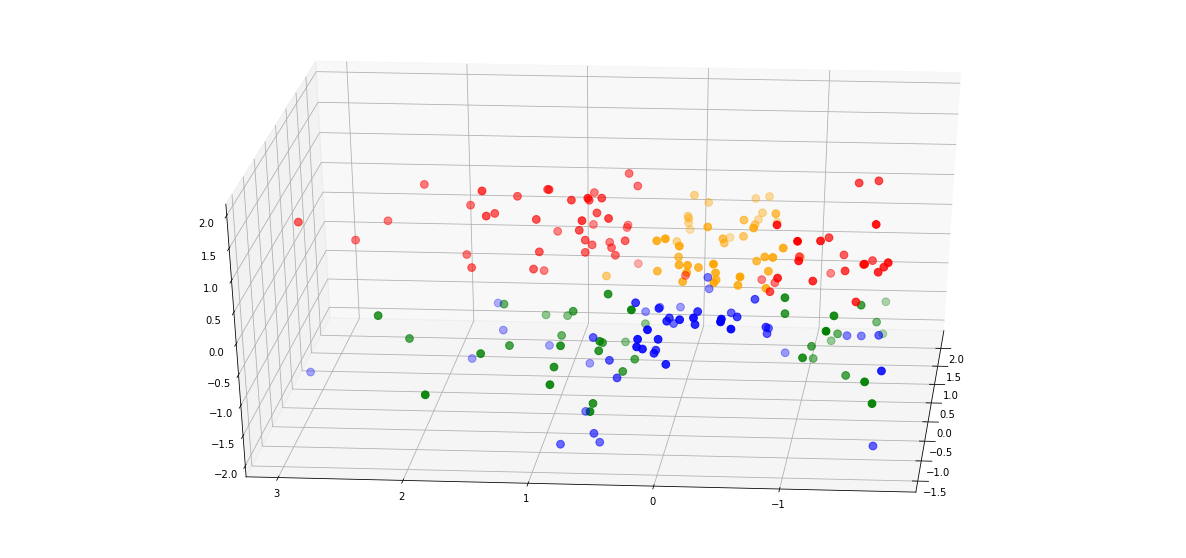

In [ ]:
clusters = kmeans.fit_predict(newdf.iloc[:,1:])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)

ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)
ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

We can tell that the cluster separation isn't too great. Let's try building a better cluster.

### Building cluster model #2

We will do some feature selection this time. <br>
<br>
We can use a technique called Principle Component Analysis(PCA). <br><br>
PCA helps us reduce the dimension of a dataset. When we run PCA on a data frame, new components are created. These component explain the maximum variance in the model. <br><br>
We can select subset of these variable and include them into the K-means model.

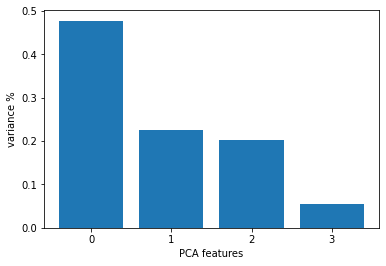

In [ ]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

The chart shows us each PCA component along with its variance. Base on this, the first 2 PCA components explain around 70% of the dataset variance. we will feed these two components into the model.<br><br>
Again, we decide the number of cluster.

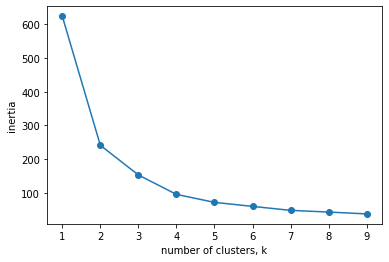

In [ ]:
inertias = []

for k in range(1,10):
  model = KMeans(n_clusters=k)
  model.fit(PCA_components.iloc[:,:2])
  inertias.append(model.inertia_)

plt.plot(range(1,10), inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range(1,10))
plt.show()

Again, it looks like the optimal clusters is 4.<br><br>
Let's evaluate new model.

#### Evaluate model #2

In [ ]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 

0.5284069579293201


Silhouette score for this model is 0.52, better than the previous one. Let's visualize the cluster for this model to see how it work:

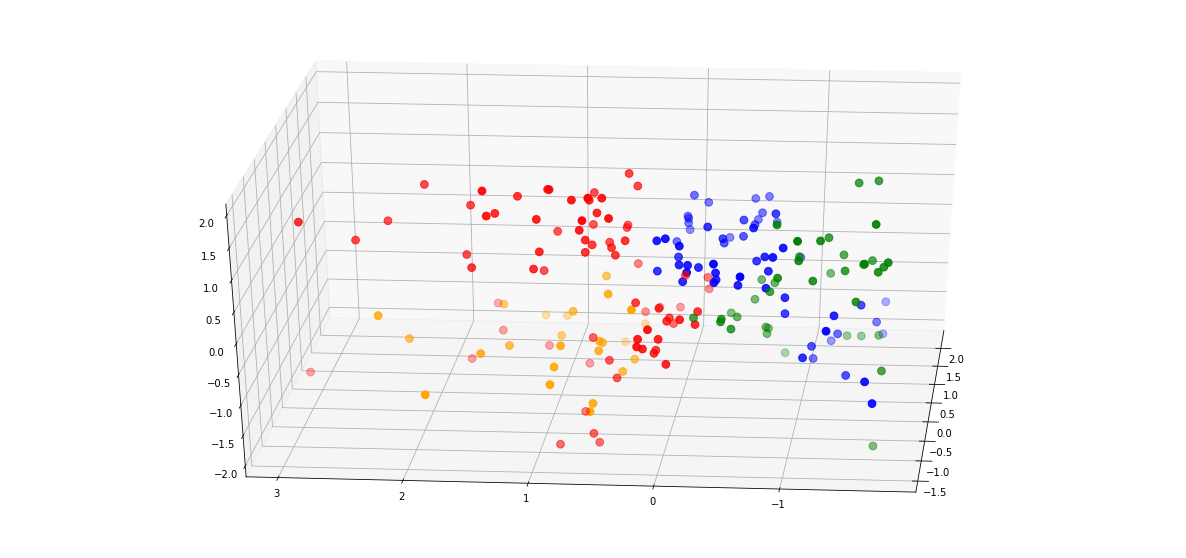

In [ ]:
model = KMeans(n_clusters=4)

clusters = model.fit_predict(PCA_components.iloc[:,:2])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)
ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)

ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

Notice that the clusters in the second model are much better separated than that in the first model. We will go foward with our analysis on this model.

### Cluster analysis

First, let's map the cluster back to the dataset and take a look at the data.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Mall_Customers.csv')
df.drop(['CustomerID'], axis=1, inplace=True)

# map back clusters to dataframe

pred = model.predict(PCA_components.iloc[:,:2])
df['cluster'] = pred
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,2
1,Male,21,15,81,2
2,Female,20,16,6,2
3,Female,23,16,77,2
4,Female,31,17,40,2


To compare attributes of the different clusters, lets find the average of all variables across each cluster:

In [ ]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,54.633333,46.666667,40.633333
1,1,30.400000,78.666667,61.720000
2,2,26.250000,30.750000,64.025000
3,3,46.480000,87.280000,16.480000


We can interpret these cluster more easily if we visualized them.

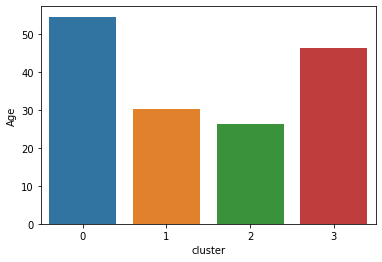

In [ ]:
sns.barplot(x='cluster',y='Age',data=avg_df)

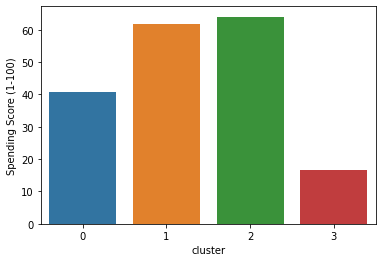

In [ ]:
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df)

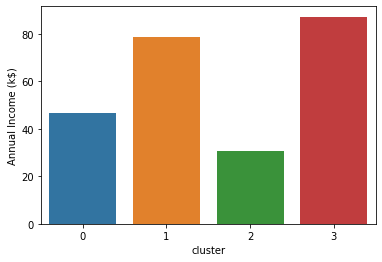

In [ ]:
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df)

Gender breakdown

In [ ]:
df.groupby(['cluster','Gender']).Age.count()


cluster  Gender
0        Female    34
         Male      26
1        Female    43
         Male      32
2        Female    25
         Male      15
3        Female    10
         Male      15
Name: Age, dtype: int64

####Main attributes of each segment<br><br>
Cluster 0:

Low to mid average income, average spending capacity.
Mean age is around 50 and gender is predominantly female.<br><br>
Cluster 1:

High average income, high spending score.
Mean age is around 30 and gender is predominantly female.<br><br>
Cluster 2:

Low average income, high spending score.
Mean age is around 25 and gender is predominantly female.<br><br>
Cluster 3:

High average annual income, low spending.
Mean age is around 40 and gender is predominantly male.<br><br>



It is important to note that calculating the median age would provide better insight on the distribution of age within each cluster.<br><br>

Also, females are more highly represented in the entire dataset, which is why most clusters contain a larger number of females than males. We can find the percentage of each gender relative to the numbers in the entire dataset to give us a better idea of gender distribution.